## check swot pixc height with geoid height. 
1. convert pixc height to raster data.

In [15]:
import numpy as np
import xarray as xr
import geopandas as gpd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from utils.pixc2raster import pixc2raster
from utils.functions import meter2deg, raster_directional_stats


In [ ]:
dir_pixc = 'data/dianchi-lake/pixc'
paths_pixc_height = sorted(glob(dir_pixc + '/*height.nc'))  # Get the first .nc file in the directory
path_lake_vec = 'data/dianchi-lake/dianchi_vector_edit.gpkg'


In [17]:
## 1. read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
## 2. read pixel cloud data
id_pixc = 3
pixc_height_nc = xr.open_dataset(paths_pixc_height[id_pixc])
pixc_height_nc


<xarray.Dataset> Size: 8MB
Dimensions:                (points: 258465)
Coordinates:
    latitude               (points) float64 2MB ...
    longitude              (points) float64 2MB ...
Dimensions without coordinates: points
Data variables:
    height                 (points) float32 1MB ...
    pixc_height_geoid      (points) float32 1MB ...
    pixc_height_geoid_cor  (points) float64 2MB ...
Attributes:
    description:  Height of the lake surface relative to the geoid and the co...
    date:         2024-04-19

In [18]:
xmin, ymin, xmax, ymax = lake_gdf.geometry[0].buffer(0.01).bounds
raster_extent = (xmin, xmax, ymin, ymax)
print('Raster extent:', raster_extent)
lat_center = pixc_height_nc.latitude.mean().values
res_lon, res_lat = meter2deg(meter=200, lat=lat_center)
print('Resolution (lat, lon):', res_lat, res_lon)


Raster extent: (102.58815361566569, 102.79447837846767, 24.659428824830986, 24.973096011780328)
Resolution (lat, lon): 0.0017986432118374611 0.0019818323258813495


In [19]:
height_geoid = pixc2raster(pixc_var = pixc_height_nc.pixc_height_geoid.values, 
                        pixc_lonlat=(pixc_height_nc.longitude.values, pixc_height_nc.latitude.values), 
                        raster_extent=raster_extent,
                        resolution=(res_lon, res_lat))
height_geoid_cor = pixc2raster(pixc_var = pixc_height_nc.pixc_height_geoid_cor.values, 
                        pixc_lonlat=(pixc_height_nc.longitude.values, pixc_height_nc.latitude.values), 
                        raster_extent=raster_extent,
                        resolution=(res_lon, res_lat))


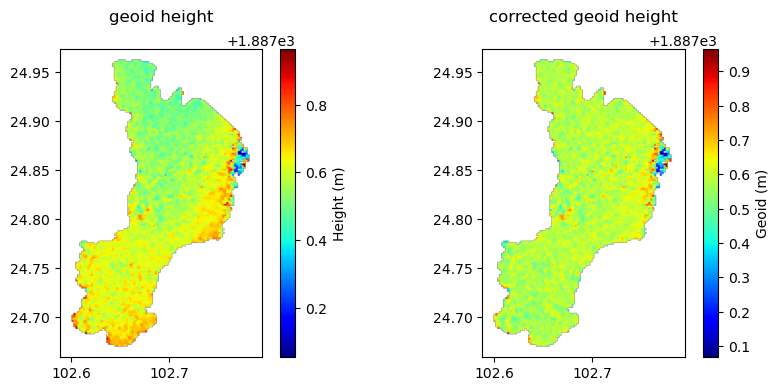

In [21]:
## show the raster data
plt.style.use('default')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
im1 = ax[0].imshow(height_geoid.values, cmap='jet', extent=raster_extent)
im2 = ax[1].imshow(height_geoid_cor.values, cmap='jet', extent=raster_extent)
ax[0].set_title('geoid height', pad=20)
ax[1].set_title('corrected geoid height', pad=20)
plt.colorbar(im1, ax=ax[0], label='Height (m)')
plt.colorbar(im2, ax=ax[1], label='Geoid (m)')



In [13]:
bin_centers_deg, height_geoid_means, height_geoid_stds = raster_directional_stats(raster_data=height_geoid.values, num_bins=12)
bin_centers_deg, height_geoid_cor_means, height_geoid_cor_stds = raster_directional_stats(raster_data=height_geoid_cor.values, num_bins=12)


Text(0.5, 1.0, 'Corrected Geoid Height')

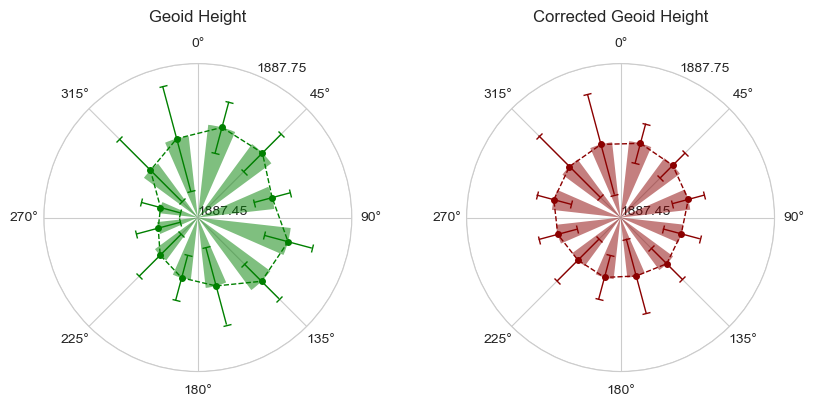

In [26]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2,  figsize=(10, 4), subplot_kw={'projection': 'polar'})
x_ticks = np.radians(bin_centers_deg)
baseline = 1887.45
range_height = 0.3
ax[0].bar(x=x_ticks, height=height_geoid_means - baseline, 
          width=0.3, color='green', edgecolor='none', alpha=0.5, bottom=baseline)
ax[0].plot(
  np.append(x_ticks, x_ticks[0]),
  np.append(height_geoid_means, height_geoid_means[0]),
  color='green', linewidth=1, linestyle='--', label='Geoid Height Mean')

ax[0].errorbar(x=x_ticks, y=height_geoid_means, 
                  yerr=height_geoid_stds, fmt='o', color='green', 
                  capsize=3, elinewidth=1, markersize=4)
ax[0].set_ylim(baseline, baseline + range_height)
ax[0].set_yticks([baseline, baseline + range_height])
ax[0].set_yticklabels([f"{baseline:.2f}", f"{(baseline + range_height):.2f}"])
ax[0].set_theta_zero_location('N')  
ax[0].set_theta_direction(-1)
ax[0].set_title('Geoid Height', pad=30)

ax[1].bar(x=x_ticks, height=height_geoid_cor_means - baseline, 
          width=0.3, color='darkred', edgecolor='none', alpha=0.5, bottom=baseline)
ax[1].errorbar(x=x_ticks, y=height_geoid_cor_means, 
                  yerr=height_geoid_cor_stds, fmt='o', color='darkred', 
                  capsize=3, elinewidth=1, markersize=4)
ax[1].plot(
  np.append(x_ticks, x_ticks[0]),
  np.append(height_geoid_cor_means, height_geoid_cor_means[0]),
  color='darkred', linewidth=1, linestyle='--', label='Geoid Height Mean')

ax[1].set_ylim(baseline, baseline + range_height)
ax[1].set_yticks([baseline, baseline + range_height])
ax[1].set_yticklabels([f"{baseline:.2f}", f"{(baseline + range_height):.2f}"])
ax[1].set_theta_zero_location('N')  
ax[1].set_theta_direction(-1)
ax[1].set_title('Corrected Geoid Height', pad=30)
